# Load Loan Portfolio

Load the loan portfolio data into a dataframe in Python. Here, we have used loan data from Prosper, an online peer-to-peer lending marketplace, for the period of 2006 to 2014 (when its data was publically available).

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("/users/rosannelai/Downloads/!IFRS 9/prosperLoanData.csv",low_memory=False)
df.replace('n/a', np.nan,inplace=True)

# Bucket Loan Portfolio According to IFRS 9 Impairment Stages

Sort the loan portfolio into the IFRS 9 impairment stages:

    Stage 1: Performing loans with low credit risk ie. are investment-grade and not late.
    
    Stage 2: Loans showing a signficiant increase in credit risk evidenced by a change from investment-grade to non-investment-grade or late 30 days.
    
    Stage 3: Credit-impaired loans ie. below investment grade. 
    
    I have added additional criteria that the Prosper loans must also be late by at least 30 days, as there have been many loans in this portfolio with a below investment-grade credit rating, but are not late. 
    
Only loans in Stages 2 and 3 are required to recognize lifetime expected credit losses ("ECL"). 


In [2]:
def IFRS9_Stage(row):
    # Stage 1: Performing loans with low credit risk ie. are investment-grade and not late. 
    if row["CreditGrade"] in ("AA","A","B") and row["LoanCurrentDaysDelinquent"] <= 30 or row["LoanStatus"]== "Completed":
        return 1
    # Stage 3: Credit-impaired loans ie. below investment grade. I have added additional criteria that the Prosper loans must also be late by at least 30 days, as there have been many loans in this portfolio with a below investment-grade credit rating, but are not late. 
    elif row["CreditGrade"] in ("C","D","E","HR") and row["LoanCurrentDaysDelinquent"] > 30 or row["LoanStatus"]== "Chargedoff " or row["LoanStatus"]== "Defaulted":   
        return 3
    # Stage 2: Loans showing a signficiant increase in credit risk evidenced by a change from investment-grade to non-investment-grade or late 30 days.
    else:
        return 2

df["IFRS9_Stage"] = df.apply(lambda row: IFRS9_Stage(row),axis=1)

# Determine the Probability of Default Over the Years

Use machine learning to calculate the probability of default ("PD") of each individual loan for each year over the life of loan. Key features fed into the model include credit rating, vintage, principal, paydowns, interest, number of days late, and years elapsed since origination.

I have used a highly simplified machine learning model here to predit PD (which was not provided in the dataset) as the focus of this demonstration is the calculation of ECL under IFRS 9. 


In [3]:
# Setting up loan default as the target feature to be used in my machine learning model to predict the probability of default ("PD").
def Loan_Status(row):
    if row["LoanStatus"] in ("Defaulted","Chargedoff"):
        return 1
    else: 
        return 0

df["LoanStatusValue"] = df.apply(lambda row: Loan_Status(row),axis=1)

In [4]:
# Calculating date features - with the Age in Days for each subsequent year from the current loan portfolio to replace the age when closed of the completed/defaulted loan portfolio.
from datetime import datetime

df["LoanOriginationDate"] = df["LoanOriginationDate"].apply(lambda x: datetime.strptime(str(x),"%d/%m/%Y %H:%M:%S"))
df["ClosedorCurrentDate"] = df["ClosedorCurrentDate"].apply(lambda x: datetime.strptime(str(x),"%d/%m/%Y %H:%M:%S"))

df["AgeDays"] = datetime.strptime("31/03/2014 00:00:00","%d/%m/%Y %H:%M:%S") - df["LoanOriginationDate"]
df["AgeDays"] = df["AgeDays"].dt.days.astype (int)

df["AgeWhenClosed"] = df["ClosedorCurrentDate"] - df["LoanOriginationDate"]
df["AgeWhenClosed"] = df["AgeWhenClosed"].dt.days.astype (int)

df["ClosedDays"] = datetime.strptime("31/03/2014 00:00:00","%d/%m/%Y %H:%M:%S")- df["ClosedorCurrentDate"]
df["ClosedDays"] = df["ClosedDays"].dt.days.astype (int)

In [5]:
# Splitting the population of completed or defaulted loans (ie. non-current) into test and training sets. We will only use closed loans in our training set since we can compare the performance of the model's prediction against the actual outcome.
dfClosedorDefaulted = df[df["ClosedDays"]>0]
train = dfClosedorDefaulted.sample(frac=0.8,random_state=200)
test = dfClosedorDefaulted.drop(train.index)

In [6]:
# Setting the loan default status as the target, and the features below of the training and test sets.
# Key features fed into the model include credit rating, vintage, principal, paydowns, interest, number of days late, and years elapsed since origination.

target_train = train["LoanStatusValue"].values

features_train = train [["AgeWhenClosed","Term","LP_CustomerPrincipalPayments","LoanOriginalAmount","LoanCurrentDaysDelinquent","LP_InterestandFees"]]
features_train = features_train.join(pd.get_dummies(train["CreditGrade"]))
features_train = features_train.values


target_test = test["LoanStatusValue"].values

features_test = test [["AgeWhenClosed","Term","LP_CustomerPrincipalPayments","LoanOriginalAmount","LoanCurrentDaysDelinquent","LP_InterestandFees"]]
features_test = features_test.join(pd.get_dummies(test["CreditGrade"]))
features_test = features_test.values

In [7]:
# Fitting my Random Forest machine learning model

from sklearn.ensemble import RandomForestClassifier

my_forest = RandomForestClassifier(max_depth=14,min_samples_split=100,random_state=1)
my_forest = my_forest.fit (features_train, target_train)

In [8]:
# Using machine learning to predit the probability of default ("PD") of each loan by feeding in key features (credit rating, vintage, principal, paydowns, interest, number of days late, and years elapsed since origination). 
#Loop for each subsequent year since origination through the life of the loan (the maximum term for a Prosper loan is 5 years).

for t in range (1,6):
    
    features_df = df.loc[:,["AgeDays","Term","LP_CustomerPrincipalPayments","LoanOriginalAmount","LoanCurrentDaysDelinquent","LP_InterestandFees"]]
    features_df = features_df.join(pd.get_dummies(df["CreditGrade"]))
    features_df["AgeDays"] = df["AgeDays"]+(t-1)*365
    features_df = features_df.values

    my_prediction_df = my_forest.predict_proba (features_df)
    df["PD"+str(t)] = pd.DataFrame (my_prediction_df[:,1], index = df.index, columns = ["PD"+str(t)], dtype=float)

# Determine the Loss Given Default and Exposure at Default

For simplicity, we will assume a loss given default ("LGD") of 100% ie. nothing can be recovered from collection efforts once the loan has defaulted. 

Exposure at default ("EAD") is determined for each hypothetical year through the lifetime loan as part of the expected lifetime credit loss calculation. EAD is equal to the outstanding balance on the loan less any credit losses recognized in previous hypothetical years.

In [9]:
# Assume a loss given default ("LGD") of 100%.
for t in range (1,6):
    df["LGD"+str(t)] = 100/100

In [10]:
# Calculating exposure at default ("EAD") of each loan for each year throughout its life.  
df["EAD1"] = df["LoanOriginalAmount"] - df["LP_CustomerPrincipalPayments"]

for t in range (2,6):
    df["EAD"+str(t)] = df["EAD"+str(t-1)] * (1 - df["PD"+str(t-1)]) * df["LGD"+str(t-1)]

# Calculate Lifetime Expected Credit Losses

ECL is calculated per IFRS 9 as the Exposure at Default (ie. balance outstanding, "EAD") * Loss Given Default (ie. % of the EAD that cannot be collected/recovered after the event of default, "LGD") * Probability of Default ("PD"). The ECL calculation is repeated for each year left on the term of the loan and aggregated at its present value to arrive at the lifetime ECL of the loan.

We can also calculate the loss rate of each loan as the lifetime expeted credit loss over the original loan principal.

In [11]:
# Calculating the expected credit loss ("ECL") of each loan for each year throughout its life, calculated as the exposure at default ("EAD") at the reporting date multiplied by the loss given default ("LGD") multiplied by the probability of default ("PD"). 
# Calculating the lifetime expected credit loss of each loan as the aggregate of the PV of expected credit losses calculated for each year throughout its life. 

df["Total_ECL"] = 0

def ECL_Calc (row,t):
    if row["LoanStatus"] in ("Defaulted","Chargedoff","Completed"):
        return 0
    if row["AgeDays"]+(t-1)*365 > row["Term"]*30:
        return 0
    if row["IFRS9_Stage"]==1 and t>1:
        return 0
    else:
        return row["PD"+str(t)]* row["EAD"+str(t)] * row["LGD"+str(t)]

for t in range (1,6):
    df["ECL"+str(t)] = df.apply(lambda row: ECL_Calc(row,t),axis=1)
    df["ECL"+str(t)+"_%"] = df["ECL"+str(t)]/df["LoanOriginalAmount"]
    df["PV_ECL"+str(t)] = df["ECL"+str(t)]/(1+df["LenderYield"])**t
    df["Total_ECL"] = df["Total_ECL"] + df["PV_ECL"+str(t)] 

In [12]:
# Calculating the loss rate of each loan 
df["Total_ECL_%"] = df["Total_ECL"] / df["LoanOriginalAmount"]

# Visualize Loan Data

## Probability of Default (Individual Loans in IFRS 9 Stage 2 or 3)

With Python, we can easily visualize the predicted probability of default of every single loan in the portfolio throughout its lifetime. We can see that it is not as easy to read as the portfolio average, but may be useful to identify outliers.

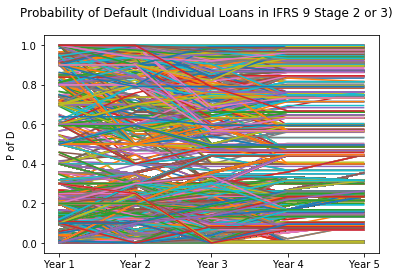

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt

df_graph1 = df[["PD1","PD2","PD3","PD4","PD5"]][(df["IFRS9_Stage"]>1)&(df["ClosedDays"]==0)&(df["AgeDays"]+365<df["Term"]*30)]

xticks=["Year 1","Year 2","Year 3","Year 4","Year 5"]
x=[1,2,3,4,5]
y=df_graph1.transpose()
plt.plot(x,y)
plt.xticks(x,xticks)
plt.suptitle('Probability of Default (Individual Loans in IFRS 9 Stage 2 or 3)')
plt.ylabel('P of D')
plt.show()

## Average Probability of Default (all)
To see the trends of the loan portfolio as a whole, we can visualize the average probability of default throughout its lifetime.
Here, we see that the our machine learning model has predicted that the average probability of deafult increases as the years elapsed since origination increases - which is reasonable.

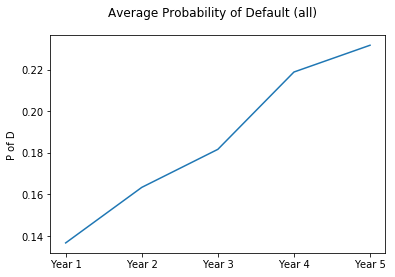

In [14]:
df_graph1 = df[["PD1","PD2","PD3","PD4","PD5"]][(df["ClosedDays"]==0)].mean()

xticks=["Year 1","Year 2","Year 3","Year 4","Year 5"]
x=[1,2,3,4,5]
plt.plot(x,df_graph1)
plt.xticks(x,xticks)
plt.suptitle('Average Probability of Default (all)')
plt.ylabel('P of D')
    
plt.show()

## Average Probability of Default (IFRS 9 Stage 2 or 3)
We can also separately visualize the average probability of default by IFRS 9 Stage throughout the lifetime of the portfolio. Only Stages 2 and 3 are graphed as Stage 1 only recognizes the 12-month expected credit loss.

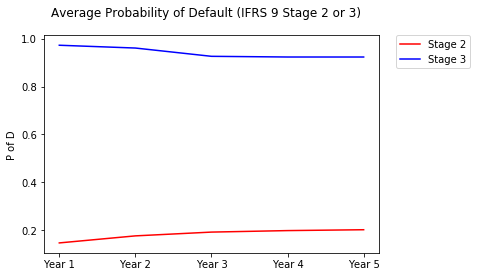

In [15]:
df_graph2 = df[["PD1","PD2","PD3","PD4","PD5"]][(df["ClosedDays"]==0)&(df["IFRS9_Stage"]==2)].mean()
df_graph3 = df[["PD1","PD2","PD3","PD4","PD5"]][(df["ClosedDays"]==0)&(df["IFRS9_Stage"]==3)].mean()

xticks=["Year 1","Year 2","Year 3","Year 4","Year 5"]
x=[1,2,3,4,5]
plt.plot(x,df_graph2,color='r',label="Stage 2")
plt.plot(x,df_graph3,color='b',label="Stage 3")
plt.xticks(x,xticks)
plt.suptitle('Average Probability of Default (IFRS 9 Stage 2 or 3)')
plt.ylabel('P of D')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
plt.show()

## Expected Credit Loss by IFRS 9 Stage
Next, we will visualize total expected credit losses by IFRS 9 Stage. 
Note that Stage 1 only shows 12-month expected credit losses instead of lifetime. Also note that there are not many Stage 3 loans in our portfolio. 


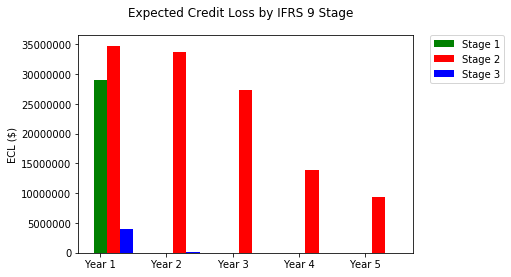

In [16]:
# Visualizing total expected credit losses by IFRS 9 Stage. 
a = df[["ECL1","ECL2","ECL3","ECL4","ECL5"]][df["IFRS9_Stage"]==1].sum()
b = df[["ECL1","ECL2","ECL3","ECL4","ECL5"]][df["IFRS9_Stage"]==2].sum()
c = df[["ECL1","ECL2","ECL3","ECL4","ECL5"]][df["IFRS9_Stage"]==3].sum()

x=[0.8,1.8,2.8,3.8,4.8]
y=[1,2,3,4,5]
z=[1.2,2.2,3.2,4.2,5.2]

ax = plt.subplot(111)
ax.bar(x, a,width=0.2,color='g',align='center',label="Stage 1")
ax.bar(y, b,width=0.2,color='r',align='center',label="Stage 2")
ax.bar(z, c,width=0.2,color='b',align='center',label="Stage 3")

yticks=["Year 1","Year 2","Year 3","Year 4","Year 5"]

plt.xticks(x,xticks)
plt.ticklabel_format(style='plain', axis='y')

plt.suptitle('Expected Credit Loss by IFRS 9 Stage')
plt.ylabel('ECL ($)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

## Expected Credit Loss to Number of Loans Still Outstanding by Year
Here, we are visualizing expected credit losses against the number of loans before maturity. 
We can see that the expected credit loss dips faster than the number of loans outstanding as Stage 1 loans would not have any expected credit losses beyond 12 months recognized at the current reporting period. 

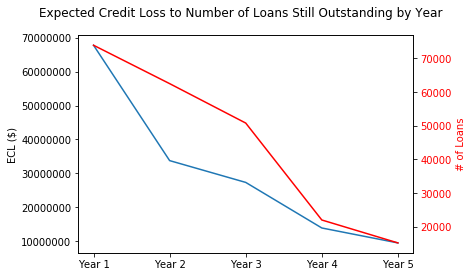

In [17]:
df_graph1 = df[["ECL1","ECL2","ECL3","ECL4","ECL5"]].sum()

df_graph2 = []
for t in range (1,6):
    df_graph2.append(df[df["AgeDays"]+(t-1)*365 < df["Term"]*30].shape[0])

xticks=["Year 1","Year 2","Year 3","Year 4","Year 5"]
x=[1,2,3,4,5]
y=df_graph1.transpose()
plt.plot(x,y)
plt.xticks(x,xticks)
plt.ticklabel_format(style='plain', axis='y',label="ECL ($)")
plt.ylabel('ECL ($)')

plt2 = plt.twinx()
plt2.plot(x,df_graph2, 'r-')
plt2.ticklabel_format(style='plain', axis='y',label="# of Loans")
for tl in plt2.get_yticklabels():
    tl.set_color('r')
plt2.set_ylabel('# of Loans', color='r')
    
plt.suptitle('Expected Credit Loss to Number of Loans Still Outstanding by Year')

plt.show()

## Loss Rate Over Time (by Principal)
Visualizing average loss rates by loan principal buckets shows that loans with larger principal are more risky.


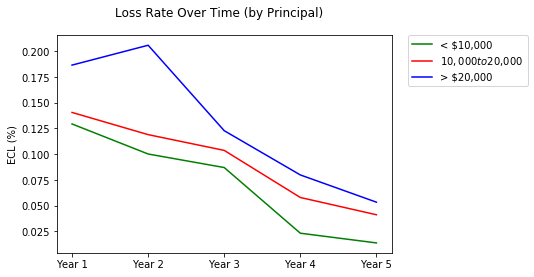

In [18]:

df_graph1 = df[["ECL1_%","ECL2_%","ECL3_%","ECL4_%","ECL5_%"]][(df["ClosedDays"]==0)&(df["LoanOriginalAmount"]<10000)&(df["IFRS9_Stage"]>1)].mean()
df_graph2 = df[["ECL1_%","ECL2_%","ECL3_%","ECL4_%","ECL5_%"]][(df["ClosedDays"]==0)&(df["LoanOriginalAmount"]<20000)&(df["LoanOriginalAmount"]>=10000)&(df["IFRS9_Stage"]>1)].mean()
df_graph3 = df[["ECL1_%","ECL2_%","ECL3_%","ECL4_%","ECL5_%"]][(df["ClosedDays"]==0)&(df["LoanOriginalAmount"]>=20000)&(df["IFRS9_Stage"]>1)].mean()

xticks=["Year 1","Year 2","Year 3","Year 4","Year 5"]
x=[1,2,3,4,5]
plt.plot(x,df_graph1,color='g',label="< $10,000")
plt.plot(x,df_graph2,color='r',label="$10,000 to $20,000")
plt.plot(x,df_graph3,color='b',label="> $20,000")
plt.suptitle('Loss Rate Over Time (by Principal)')
plt.ylabel('ECL (%)')
plt.xticks(x,xticks)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Loss Rate Over Time (by Number of Days Delinquent)
Visualizing average loss rates by number of days delinquent shows that loans that are late by 30 days are more risky, but the loss rate dips after Year 1 as it is most likely to default within 12 months if already 30 days late.


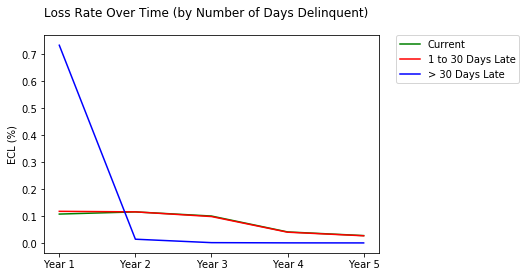

In [19]:
df_graph1 = df[["ECL1_%","ECL2_%","ECL3_%","ECL4_%","ECL5_%"]][(df["ClosedDays"]==0)&(df["LoanCurrentDaysDelinquent"]==0)&(df["IFRS9_Stage"]>1)].mean()
df_graph2 = df[["ECL1_%","ECL2_%","ECL3_%","ECL4_%","ECL5_%"]][(df["ClosedDays"]==0)&(df["LoanCurrentDaysDelinquent"]<=30)&(df["LoanOriginalAmount"]>0)&(df["IFRS9_Stage"]>1)].mean()
df_graph3 = df[["ECL1_%","ECL2_%","ECL3_%","ECL4_%","ECL5_%"]][(df["ClosedDays"]==0)&(df["LoanCurrentDaysDelinquent"]>30)&(df["IFRS9_Stage"]>1)].mean()

xticks=["Year 1","Year 2","Year 3","Year 4","Year 5"]
x=[1,2,3,4,5]
plt.plot(x,df_graph1,color='g',label="Current")
plt.plot(x,df_graph2,color='r',label="1 to 30 Days Late")
plt.plot(x,df_graph3,color='b',label="> 30 Days Late")
plt.suptitle('Loss Rate Over Time (by Number of Days Delinquent)')
plt.ylabel('ECL (%)')
plt.xticks(x,xticks)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Loss Rate Over Time (by IFRS 9 Stage)
Lastly, here we are visualizing loss rates by IFRS 9 stage. 
Note that only Stages 2 and 3 are shown as the loss rate would only apply to the first year for Stage 1 loans.


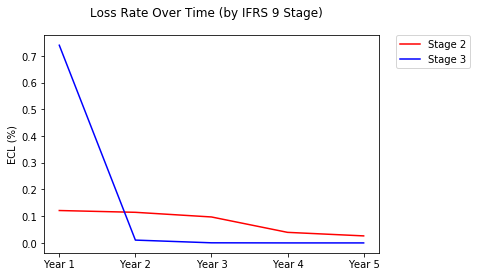

In [20]:
df_graph2 = df[["ECL1_%","ECL2_%","ECL3_%","ECL4_%","ECL5_%"]][(df["ClosedDays"]==0)&(df["IFRS9_Stage"]==2)].mean()
df_graph3 = df[["ECL1_%","ECL2_%","ECL3_%","ECL4_%","ECL5_%"]][(df["ClosedDays"]==0)&(df["IFRS9_Stage"]==3)].mean()

xticks=["Year 1","Year 2","Year 3","Year 4","Year 5"]
x=[1,2,3,4,5]
plt.plot(x,df_graph2,color='r',label="Stage 2")
plt.plot(x,df_graph3,color='b',label="Stage 3")
plt.suptitle('Loss Rate Over Time (by IFRS 9 Stage)')
plt.ylabel('ECL (%)')
plt.xticks(x,xticks)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()